<a href="https://colab.research.google.com/github/Janardan-thapaliya/Deep_Learning_SNN/blob/main/Object_detection_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow snntorch torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import numpy as np
import tensorflow as tf
import snntorch as snn
from tensorflow.keras.utils import to_categorical
import torch

# Load N-MNIST dataset (download it if needed)
def load_nmnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Normalize pixel values to [0,1] and add channel dimension
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    x_train = np.expand_dims(x_train, axis=-1)  # Shape (samples, 28, 28, 1)
    x_test = np.expand_dims(x_test, axis=-1)

    # Convert labels to one-hot encoding
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    return x_train, y_train, x_test, y_test

# Load dataset
X_train, y_train, X_test, y_test = load_nmnist()

# Print shapes
print("Training data shape:", X_train.shape)  # (60000, 28, 28, 1)
print("Test data shape:", X_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


In [3]:
def poisson_encoding(image, time_steps=10):
    """Convert an image to spike train using Poisson encoding."""
    spike_train = np.random.rand(time_steps, *image.shape) < image
    return spike_train.astype(np.float32)

# Convert entire dataset
time_steps = 10  # Number of time steps for spikes
X_train_spikes = np.array([poisson_encoding(img, time_steps) for img in X_train])
X_test_spikes = np.array([poisson_encoding(img, time_steps) for img in X_test])

print("Spike Train shape:", X_train_spikes.shape)  # (60000, 10, 28, 28, 1)


Spike Train shape: (60000, 10, 28, 28, 1)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, TimeDistributed
from tensorflow.keras import backend as K

# Define the Spiking Neural Network Model
def build_snn():
    model = Sequential([
        TimeDistributed(Conv2D(16, (3, 3), padding="same", activation="relu"), input_shape=(time_steps, 28, 28, 1)),
        BatchNormalization(),
        TimeDistributed(Conv2D(32, (3, 3), padding="same", activation="relu")),
        BatchNormalization(),
        TimeDistributed(Flatten()),
        Dense(128, activation="relu"),
        Dense(10, activation="softmax")  # The final output layer
    ])

    # Adding a Lambda layer to select the last time step's output for classification
    model.add(tf.keras.layers.Lambda(lambda x: x[:, -1, :]))  # Taking the last time step

    return model

# Create the model
snn_model = build_snn()

# Compile the model
snn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print summary
snn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 10, 28, 28, 16)      │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 28, 28, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 28, 28, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 28, 28, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 10, 25088)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10, 128)             │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10, 10)              │           1,290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,217,674 (12.27 MB)

 Trainable params: 3,217,578 (12.27 MB)

 Non-trainable params: 96 (384.00 B)

In [5]:
# Train the model
history = snn_model.fit(
    X_train_spikes, y_train,
    validation_data=(X_test_spikes, y_test),
    epochs=5, batch_size=32
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 673s 357ms/step - accuracy: 0.8976 - loss: 0.4298 - val_accuracy: 0.9737 - val_loss: 0.0949
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 678s 362ms/step - accuracy: 0.9822 - loss: 0.0590 - val_accuracy: 0.9558 - val_loss: 0.1617
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 660s 352ms/step - accuracy: 0.9895 - loss: 0.0331 - val_accuracy: 0.9748 - val_loss: 0.0931
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 633s 338ms/step - accuracy: 0.9936 - loss: 0.0211 - val_accuracy: 0.9722 - val_loss: 0.1349
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 627s 335ms/step - accuracy: 0.9939 - loss: 0.0205 - val_accuracy: 0.9764 - val_loss: 0.1171


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


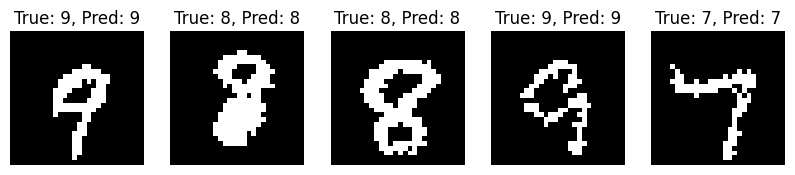

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot predictions
def plot_predictions(X_test_spikes, y_test, model, num_samples=5):
    plt.figure(figsize=(10, 10))

    for i in range(num_samples):
        # Random index
        idx = np.random.randint(0, len(X_test_spikes))

        # Get the image and label
        image = X_test_spikes[idx]
        true_label = np.argmax(y_test[idx])

        # Predict the label for the image
        predicted_label = np.argmax(model.predict(np.expand_dims(image, axis=0)))

        # Plot the image
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image[0], cmap="gray")  # Assuming image has shape (time_steps, height, width, 1)
        plt.title(f"True: {true_label}, Pred: {predicted_label}")
        plt.axis('off')

    plt.show()

# Call the function to plot predictions
plot_predictions(X_test_spikes, y_test, snn_model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step


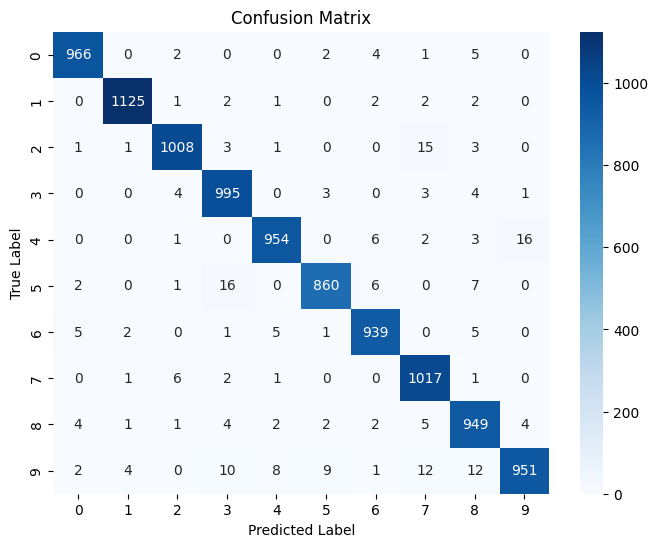

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the entire test set
y_pred = np.argmax(snn_model.predict(X_test_spikes), axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()